<a href="https://colab.research.google.com/github/jhihan/Conway-s-Game-of-Life-Neural-Network-/blob/master/Game_of_Life_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Conway's Game of Life
## Rule of Conway's Game of Life
The follwing states is copied from wikipedia page of [Conway's Game of Life](https://en.wikipedia.org/wiki/Conway%27s_Game_of_Life):

---
The universe of the Game of Life is an infinite, two-dimensional orthogonal grid of square cells, each of which is in one of two possible states, alive or dead, (or populated and unpopulated, respectively). Every cell interacts with its eight neighbours, which are the cells that are horizontally, vertically, or diagonally adjacent. At each step in time, the following transitions occur:

* Any live cell with fewer than two live neighbours dies, as if by underpopulation.
* Any live cell with two or three live neighbours lives on to the next generation.
* Any live cell with more than three live neighbours dies, as if by overpopulation.
* Any dead cell with exactly three live neighbours becomes a live cell, as if by reproduction.

---
We can change rules by assigning the number of live neighbors (n_rebirth) which ensures the cell live and rebirth. For example, the original rules is n_rebirth =3: the cell can live or rebirth with 3 (n_rebirth) live neighbours, and the live cell which can still survive with 2 (n_rebirth-1) live neighbors. We can change the rules by setting n_rebirth to be between 2 and 8.
## Goal
The goal of this project is using deep learning methods to train the machine to :

1. predict the pattern evolution without knowing the rule
2. infere the rules from the given pattern evolutions which are produced by different rules (the model doesn't know the rules in the beginning). 



In [0]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPool2D, Flatten, SimpleRNN, TimeDistributed, LSTM
from keras.utils import np_utils
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

Define the basic functions. The function life_step determines the next pattern with the current pattern and the given rules. The parameter "edge" determines how to deal with the behavior in the boundary. The original Conway's game of life have infinite rnage. For simplicity, here we define two scenario: 

1. edge = "wrapped": The boarders are wrapped:

 * The top row wraps to the bottom row.
 * The left side row wraps to the right side row (and vice versa).
 * The top-left cell wraps to the bottom-right cell (and vice versa).

2. edge = "die" : The cells outside the boarder are considered as dead cells.

In [0]:
def life_step(X, N_rebirth = 3, edge = 'wrapped' ):
    assert (N_rebirth >1 or N_rebirth < 9 ), "N_rebirth should be between[2,8]"
    assert (edge == 'wrapped' or edge == 'die'), "x should be 'wrapped'(default) or 'die'"
    if( edge == 'wrapped' ):
      live_neighbors = sum(np.roll(np.roll(X, i, 0), j, 1)
                       for i in (-1, 0, 1) for j in (-1, 0, 1)
                       if (i != 0 or j != 0))
    elif( edge == 'die' ):
      pad_width = {1: (1,0) , 0: (0,0) , -1: (0,1)}
      slice0 = {1: slice(0,-1) , 0: slice(0,X.shape[0]) , -1: slice(1,X.shape[0]+1)}
      slice1 = {1: slice(0,-1) , 0: slice(0,X.shape[1]) , -1: slice(1,X.shape[1]+1)}
      live_neighbors = sum( np.pad(X,(pad_width[i],pad_width[j]) , mode='constant')[slice0[i],slice0[j]]
                           for i in (-1, 0, 1) for j in (-1, 0, 1)
                           if (i != 0 or j != 0))
      
    return (live_neighbors == N_rebirth) | (X & (live_neighbors == N_rebirth-1)).astype(int)
def generate_frames(num_frames, board_shape=(100,100), prob_alive=0.15):
    return np.array([
        np.random.choice([False, True], size=board_shape, p=[1-prob_alive, prob_alive])
        for _ in range(num_frames)
    ]).astype(int)

def render_frames(frame1, frame2):
    plt.subplot(1, 2, 1)
    plt.imshow(frame1.flatten().reshape(board_shape), cmap='gray')

    plt.subplot(1, 2, 2)
    plt.imshow(frame2.flatten().reshape(board_shape), cmap='gray')    

In [3]:
board_shape = (20, 20)
board_size = board_shape[0] * board_shape[1]
probability_alive = 0.15
edge = 'wrapped'

frames = generate_frames(10, board_shape=board_shape, prob_alive=probability_alive)
print(frames.shape) # (num_frames, board_w, board_h)

(10, 20, 20)


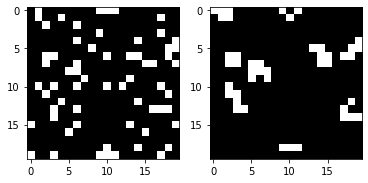

In [4]:
render_frames(frames[1], life_step(frames[1],3,edge) )

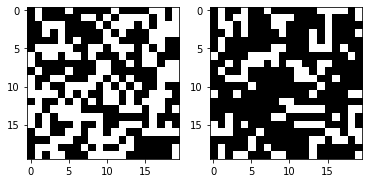

In [5]:
board_shape = (20, 20)
board_size = board_shape[0] * board_shape[1]
probability_alive = 0.5
edge = 'wrapped'

frames = generate_frames(10, board_shape=board_shape, prob_alive=probability_alive)
render_frames(frames[1], life_step(frames[1],3,edge) )

Define the function generating the datasets, which contains a set of current pattern and the next pattern.

In [0]:
def reshape_input(X):
    return X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)

def generate_dataset(num_frames, board_shape, prob_alive, N_rebirth, edge = 'wrapped'):
    X = generate_frames(num_frames, board_shape=board_shape, prob_alive=prob_alive)
    X = reshape_input(X)
    y = np.array([
        life_step(frame,N_rebirth, edge) 
        for frame in X
    ])
    return X, y

def generate_life_series(num_frames, board_shape, prob_alive, N_rebirth, edge = 'wrapped'):
    X = np.array(np.random.choice([False, True], size=board_shape, p=[1-prob_alive, prob_alive])).astype(int)
    X = [ X.reshape(X.shape[0], X.shape[1], 1) ]
    
    for i in range(num_frames-1):
      X.append( life_step(X[-1],N_rebirth, edge) )

    return np.array(X)

train_size = 70000
val_size   = 10000
test_size  = 20000

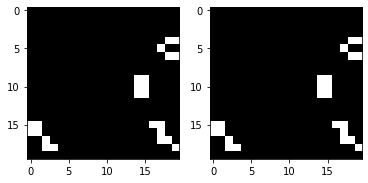

In [0]:
render_frames(X_series[2], life_step(X_series[1],N_rebirth=3,edge) )

Create the datasets

In [0]:
print("Training Set:")
X_train, y_train = generate_dataset(train_size, board_shape, probability_alive, 3)
print(X_train.shape)
print(y_train.shape)
print("Validation Set:")
X_val, y_val = generate_dataset(val_size, board_shape, probability_alive, 3)
print(X_val.shape)
print(y_val.shape)
print("Test Set:")
X_test, y_test = generate_dataset(test_size, board_shape, probability_alive, 3)
print(X_test.shape)
print(y_test.shape)

Training Set:
(70000, 20, 20, 1)
(70000, 20, 20, 1)


Validation Set:
(10000, 20, 20, 1)
(10000, 20, 20, 1)


Test Set:
(20000, 20, 20, 1)
(20000, 20, 20, 1)


With the given sets of the initial patterns and the next generations,  building a model which can predict the next generations without knowing the rules

In [0]:
# CNN Properties
filters = 16
kernel_size = (3, 3) # look at all 8 neighboring cells, plus itself
strides = 1
hidden_dims = 100
input_shape = (board_shape[0] + 2, board_shape[1] + 2, 1) if edge == 'wrapped'   else (board_shape[0], board_shape[1], 1)

In [0]:
model = Sequential()
model.add(Conv2D(
    filters, 
    kernel_size,
    padding='valid',
    activation='relu',
    strides=strides,
    input_shape=input_shape
))
model.add(Dense(hidden_dims))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [31]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 20, 20, 16)        160       
_________________________________________________________________
dense_5 (Dense)              (None, 20, 20, 100)       1700      
_________________________________________________________________
dense_6 (Dense)              (None, 20, 20, 1)         101       
_________________________________________________________________
activation_1 (Activation)    (None, 20, 20, 1)         0         
Total params: 1,961
Trainable params: 1,961
Non-trainable params: 0
_________________________________________________________________


In [0]:
def pad_input(X):
    return reshape_input(np.array([
        np.pad(x.reshape(board_shape), (1,1), mode='wrap')
        for x in X
    ]))
def train(model, X_train, y_train, X_val, y_val, batch_size=50, epochs=150, edge = 'wrapped' ):
    X_train = pad_input(X_train) if edge == 'wrapped' else X_train
    X_val = pad_input(X_val) if edge == 'wrapped' else X_val
    history = model.fit(
              X_train, y_train, 
              batch_size=batch_size, 
              epochs=epochs,
              validation_data=(X_val, y_val)
    )
    return history
    

In [0]:
train(model, X_train[0:400], y_train[0:400], X_val[0:400], y_val[0:400])

Train on 400 samples, validate on 400 samples
Epoch 1/150
400/400 [==============================] - 0s 541us/step - loss: 0.6720 - accuracy: 0.7440 - val_loss: 0.6326 - val_accuracy: 0.8810
Epoch 2/150
400/400 [==============================] - 0s 133us/step - loss: 0.6048 - accuracy: 0.8824 - val_loss: 0.5710 - val_accuracy: 0.8810
Epoch 3/150
400/400 [==============================] - 0s 137us/step - loss: 0.5470 - accuracy: 0.8824 - val_loss: 0.5184 - val_accuracy: 0.8810
Epoch 4/150
400/400 [==============================] - 0s 128us/step - loss: 0.4982 - accuracy: 0.8824 - val_loss: 0.4766 - val_accuracy: 0.8810
Epoch 5/150
400/400 [==============================] - 0s 128us/step - loss: 0.4612 - accuracy: 0.8824 - val_loss: 0.4456 - val_accuracy: 0.8810
Epoch 6/150
400/400 [==============================] - 0s 130us/step - loss: 0.4327 - accuracy: 0.8824 - val_loss: 0.4207 - val_accuracy: 0.8810
Epoch 7/150
400/400 [==============================] - 0s 131us/step - loss: 0.4088 

## Rules inference from pattern evolution of Game of Life.
With the given sets of the pattern evolution of Game of Life with different rules, building a model which can infer the rules. This is essentially a time-series classification problem.

In [0]:
def generate_life_series_classified(num_series_list, num_frames, board_shape, prob_alive, N_rebirth_list, edge = 'wrapped'):
    assert ( len(num_series_list) == len(N_rebirth_list) ), "N_rebirth_list should be equal to num_series_list"    

    X = []
    Y = []
    for n_series, n_rebirth in zip(num_series_list, N_rebirth_list):    
      for i_series in range(n_series):
        XX = np.array(np.random.choice([False, True], size=board_shape, p=[1-prob_alive, prob_alive])).astype(int)
        XX = [ XX.reshape(XX.shape[0], XX.shape[1], 1) ]
        Y.append( n_rebirth )
        for i in range(num_frames-1):
          XX.append( life_step(XX[-1], n_rebirth, edge) )
        X.append( XX )

    return np.array(X),np.array(Y)

In [0]:
train_size_list = [1000,1000]
num_frames = 20
board_shape = (20,20)
prob_alive = 0.15
N_rebirth_list = [3,4]
val_size_list = [200,200]
test_size_list = [100,100]
X_train, y_train = generate_life_series_classified(train_size_list, num_frames, board_shape, prob_alive, N_rebirth_list, edge = 'wrapped')
X_val, y_val = generate_life_series_classified(val_size_list, num_frames, board_shape, prob_alive, N_rebirth_list, edge = 'wrapped')
X_test, y_test = generate_life_series_classified(val_size_list, num_frames, board_shape, prob_alive, N_rebirth_list, edge = 'wrapped')

In [184]:
print(X_test.shape, y_test.shape)

(400, 20, 20, 20, 1) (400,)


In [0]:
def shuffle_syn( X , y ):
  temp = list(zip(X, y)) 
  random.shuffle(temp) 
  X , y = zip(*temp)
  X = np.array(X)
  y = np.array(y)
  return X,y

X_train, y_train = shuffle_syn( X_train, y_train )
X_val, y_val = shuffle_syn( X_val, y_val )
X_test, y_test = shuffle_syn( X_test, y_test )

In [0]:
class My_OneHotEncoder():
  def __init__(self):
    self.__label_encoder = LabelEncoder()
    self.__onehot_encoder = OneHotEncoder(sparse=False)

  def fit_transform(self,y_train):
    integer_encoded = self.__label_encoder.fit_transform(y_train)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = self.__onehot_encoder.fit_transform(integer_encoded)
    return onehot_encoded

  def transform(self,y_train):
    integer_encoded = self.__label_encoder.transform(y_train)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = self.__onehot_encoder.transform(integer_encoded)
    return onehot_encoded

  def inverse_transform(self, transformed, from = 'onehot', to = 'class'):
    if (from == 'onehot' and to == 'class'):
      inverted = self.__label_encoder.inverse_transform([np.argmax(transformed[0, :])])
    elif (from == 'label' and to == 'class'):
      inverted = self.__label_encoder.inverse_transform( transformed )
    elif (from == 'onehot' and to == 'label'):
      inverted = np.argmax(transformed[0, :])
    else:
      raise ValueError('(from, to) must be (onehot,class),(label,class),(onehot,label)')
    return inverted

  def inverse_transform(self, y_train_label):
    inverted = self.__label_encoder.inverse_transform( y_train_label )
    return inverted 

 # _label_encoder = LabelEncoder()
 # _onehot_encoder = OneHotEncoder(sparse=False)   

In [0]:
my_encoder = My_OneHotEncoder()
y_train_onehot = my_encoder.fit_transform(y_train)
y_val_onehot = my_encoder.fit_transform(y_val)
y_test_onehot = my_encoder.fit_transform(y_test)

### Building CNN–LSTM model for time-series classification
https://machinelearningmastery.com/cnn-long-short-term-memory-networks/

In [0]:
# CNN Properties
filters = 32
kernel_size = (3, 3) # look at all 8 neighboring cells, plus itself
strides = 1
hidden_dims = 100
input_shape = (None ,board_shape[0] + 2, board_shape[1] + 2, 1) if edge == 'wrapped'   else (num_frames ,board_shape[0], board_shape[1], 1)

In [0]:
model = Sequential()

model.add(TimeDistributed(Conv2D(filters, 
    kernel_size,
    padding='valid',
    activation='relu',
    strides=strides,
    input_shape=input_shape)))

model.add(TimeDistributed(MaxPool2D( pool_size=(2, 2) )))
model.add(TimeDistributed(Flatten()))
# define RNN model
#model.add(LSTM(units=10))
#model.add(SimpleRNN(units=10))
model.add(LSTM(units=10))
model.add(Dropout(0.2))
model.add(Dense(units=hidden_dims,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=2, kernel_initializer='normal', activation='softmax' ))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [243]:
model.build((None,) + input_shape)
model.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_79 (TimeDis (None, None, 20, 20, 32)  320       
_________________________________________________________________
time_distributed_80 (TimeDis (None, None, 10, 10, 32)  0         
_________________________________________________________________
time_distributed_81 (TimeDis (None, None, 3200)        0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 10)                128440    
_________________________________________________________________
dropout_29 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_53 (Dense)             (None, 100)               1100      
_________________________________________________________________
dropout_30 (Dropout)         (None, 100)             

In [0]:
def reshape_input_series(X):
    return X.reshape(X.shape[0], X.shape[1], X.shape[2], X.shape[3], 1)
def pad_input(X):
    return np.array([
        np.pad(x.reshape(board_shape), (1,1), mode='wrap')
        for XX in X for x in XX 
    ]).reshape( X.shape[0], X.shape[1],X.shape[2]+2, X.shape[3]+2, 1)
def train(model, X_train, y_train_onehot, X_val, y_val_onehot, batch_size=50, epochs=100, edge = 'wrapped' ):
    X_train = pad_input(X_train) if edge == 'wrapped' else X_train
    X_val = pad_input(X_val) if edge == 'wrapped' else X_val
    print(X_train.shape,X_val.shape)
    history = model.fit(
              X_train, y_train_onehot, 
              batch_size=batch_size, 
              epochs=epochs,
              validation_data=(X_val, y_val_onehot)
              )
      
    return history

In [236]:
history = train(model, X_train, y_train_onehot, X_val, y_val_onehot)

(2000, 20, 22, 22, 1) (400, 20, 22, 22, 1)
Train on 2000 samples, validate on 400 samples
Epoch 1/100
2000/2000 [==============================] - 2s 1ms/step - loss: 0.4686 - accuracy: 0.8370 - val_loss: 0.3302 - val_accuracy: 0.9850
Epoch 2/100
2000/2000 [==============================] - 2s 855us/step - loss: 0.1776 - accuracy: 0.9865 - val_loss: 0.0284 - val_accuracy: 0.9925
Epoch 3/100
2000/2000 [==============================] - 2s 878us/step - loss: 0.0511 - accuracy: 0.9900 - val_loss: 0.0232 - val_accuracy: 0.9875
Epoch 4/100
2000/2000 [==============================] - 2s 888us/step - loss: 0.0345 - accuracy: 0.9905 - val_loss: 0.0927 - val_accuracy: 0.9800
Epoch 5/100
2000/2000 [==============================] - 2s 844us/step - loss: 0.0355 - accuracy: 0.9895 - val_loss: 0.0507 - val_accuracy: 0.9850
Epoch 6/100
2000/2000 [==============================] - 2s 846us/step - loss: 0.0205 - accuracy: 0.9950 - val_loss: 0.0217 - val_accuracy: 0.9925
Epoch 7/100
2000/2000 [=======

In [0]:
# define the function of plotting training history
def show_train_history(train_history, train , validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train','validation'], loc='upper left')
    plt.show()

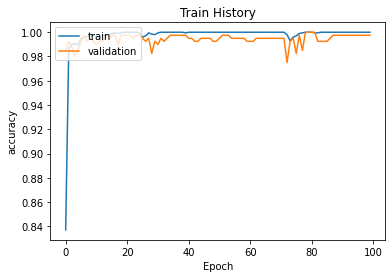

In [238]:
show_train_history( history , 'accuracy' , 'val_accuracy')

In [0]:
prediction = model.predict_classes( pad_input(X_val) )

In [240]:
pd.crosstab( y_val, prediction , rownames=['label'], colnames=['predict'])

predict,0,1
label,,
3,200,0
4,1,199
